<a href="https://colab.research.google.com/github/Mcube100/Deep_Learning_Projects_for_Coders/blob/main/fastAI_Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports all functions from fastai.vision.all for computer vision tasks
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [ ]:
files = get_image_files(path/"images")
len(files)


7390

In [ ]:
files[0],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_154.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_150.jpg'))

In [ ]:
def label_func(f): return f[0].isupper()

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.148388,0.022202,0.007442,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.067930,0.018047,0.005413,00:47


In [ ]:
learn.predict(files[0])

('False', tensor(0), tensor([1.0000e+00, 2.8688e-06]))

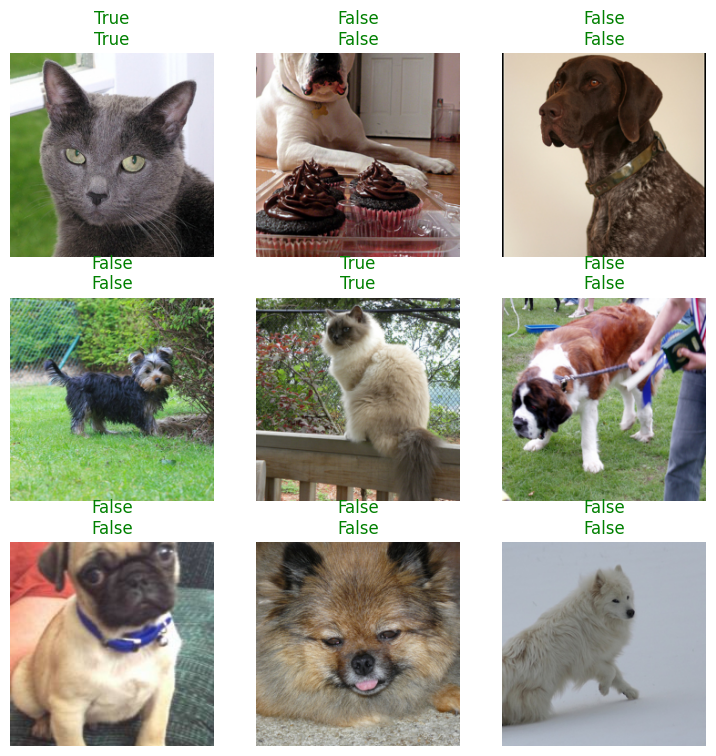

In [ ]:
learn.show_results()